# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

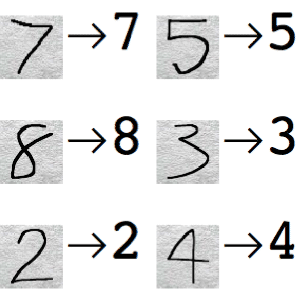

In [137]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np


# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


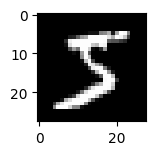

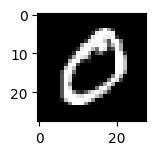

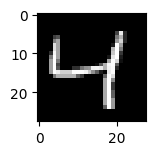

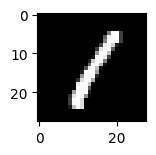

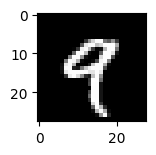

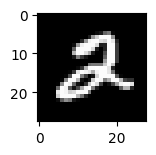

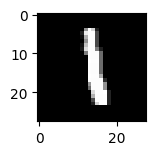

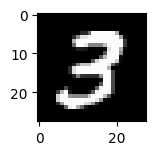

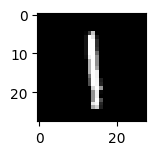

In [138]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

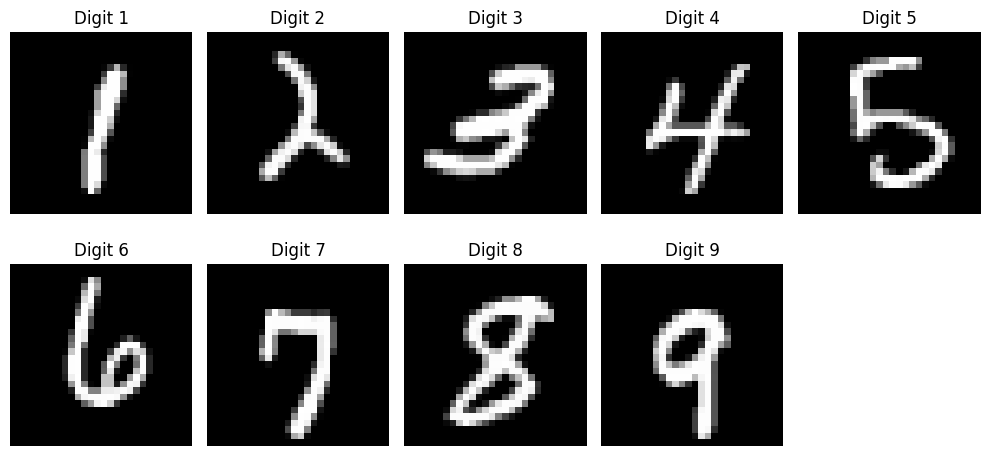

In [139]:
import numpy as np

# Create a list to store the indices of one example of each digit
digit_indices = []

# Randomly select one example of each digit from the training set
for i in range(1, 10):  # Digits 1 through 9
    # Find indices of images with label i
    indices = np.where(trainy == i)[0]
    # Randomly select one index
    random_index = np.random.choice(indices)
    # Append the selected index to the list
    digit_indices.append(random_index)

# Plot one example of each digit
plt.figure(figsize=(10, 5))
for i, index in enumerate(digit_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(trainX[index], cmap='gray')
    plt.title(f"Digit {trainy[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


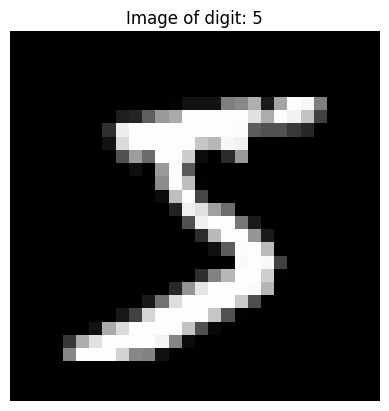

In [ ]:
import matplotlib.pyplot as plt

# Assuming trainX and trainY are already loaded and preprocessed

# Choose an index to view
index = 0  # You can choose any index within the range of your dataset size

# Display the image from trainX
plt.imshow(trainX[index], cmap='gray')
plt.title(f"Image of digit: {trainy[index]}")  # Display the corresponding label from trainY
plt.axis('off')  # Turn off axis
plt.show()

In [140]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY


## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [108]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=6):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=11, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [109]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

In [110]:
# entry point, run the test harness
run_test_harness()

> 98.550
> 98.750
> 98.880
> 98.590
> 98.860


KeyboardInterrupt: 

## Save Final Model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate Final Model

## Make Prediction

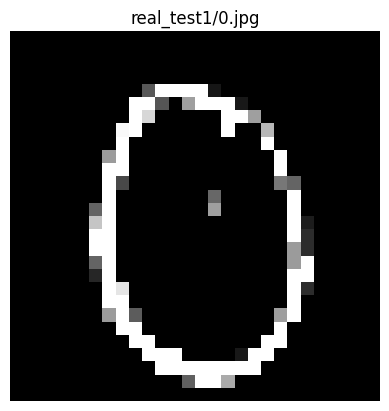

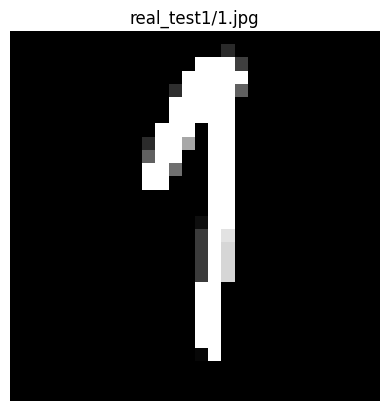

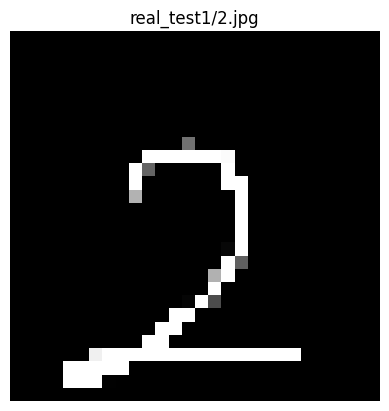

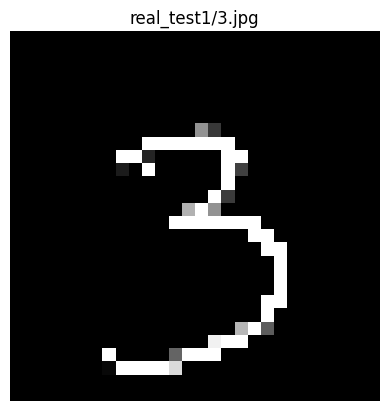

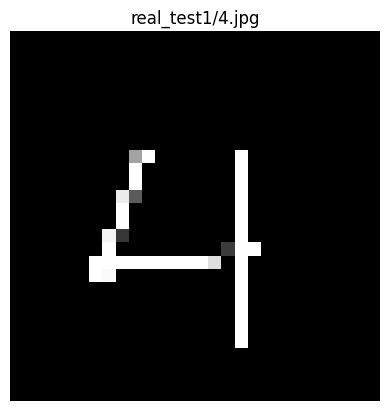

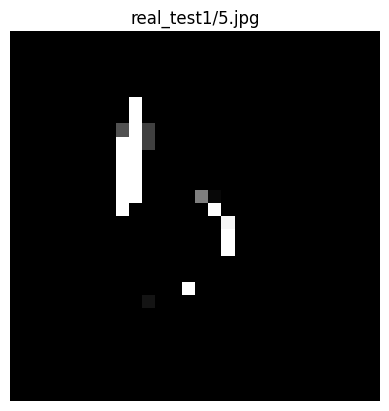

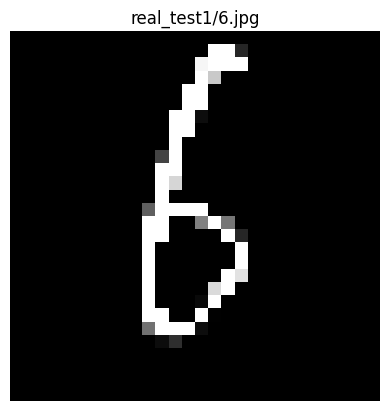

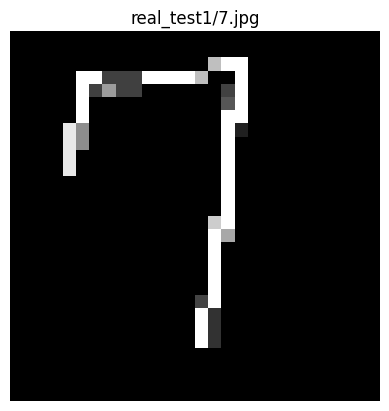

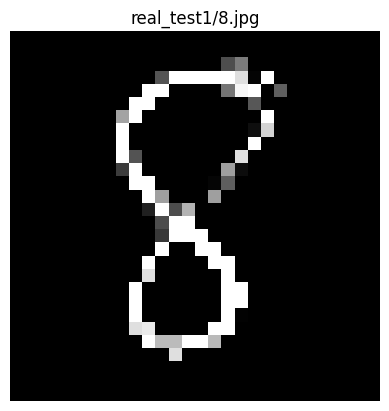

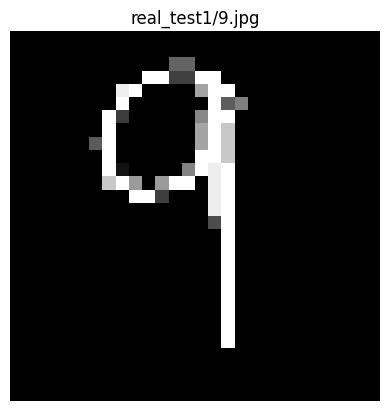

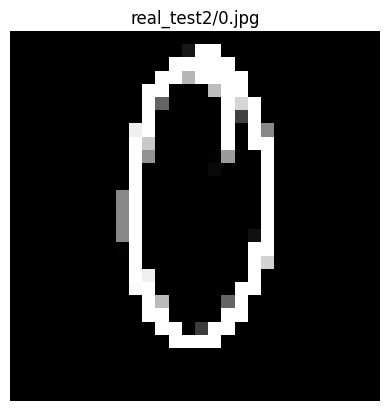

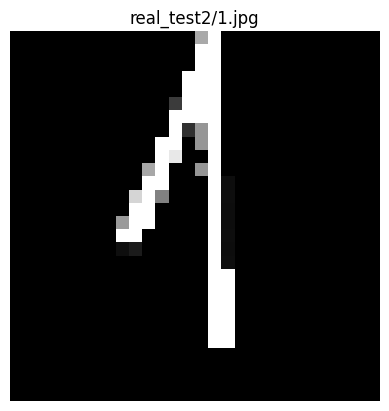

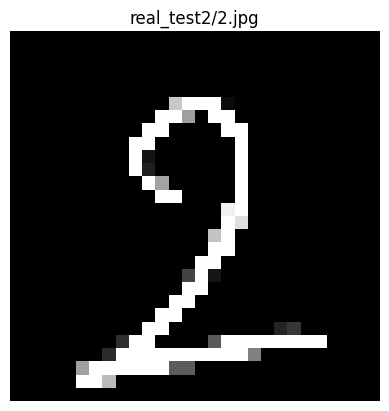

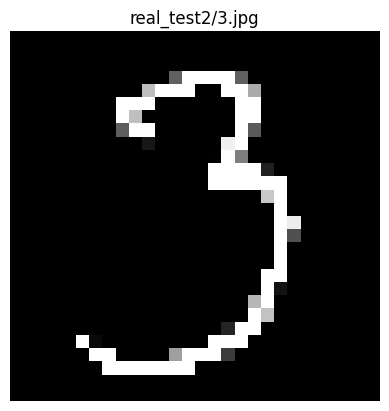

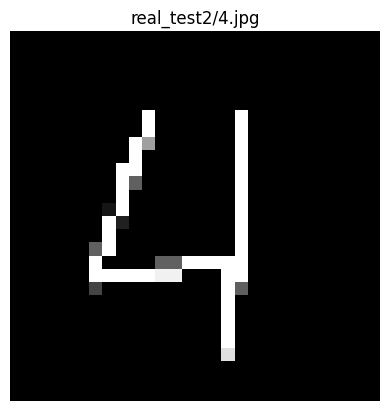

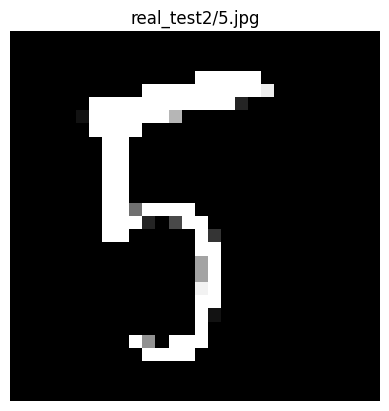

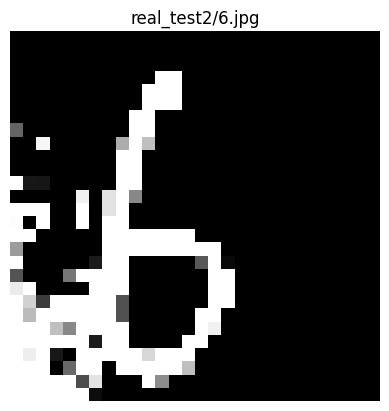

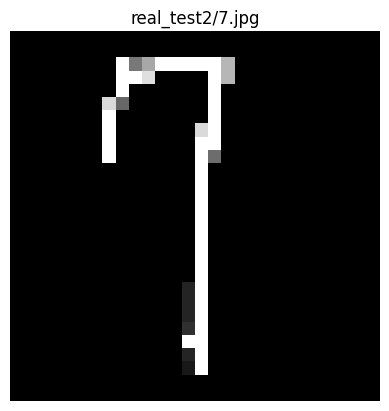

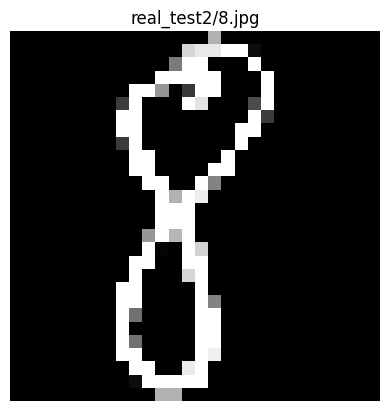

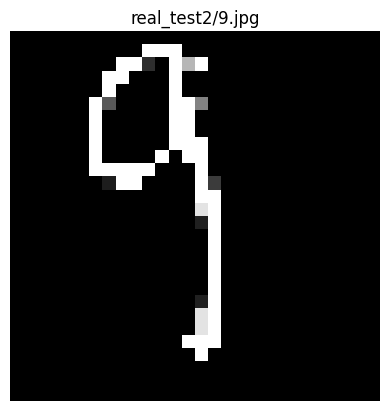

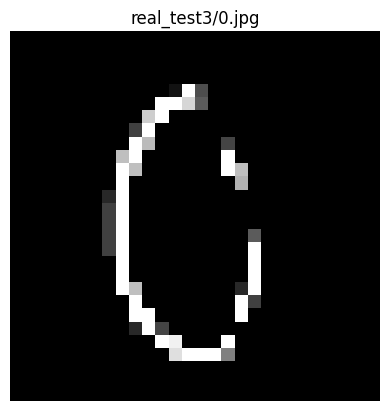

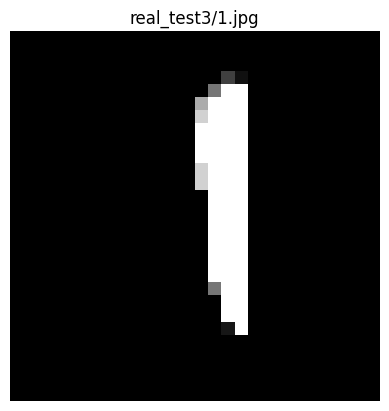

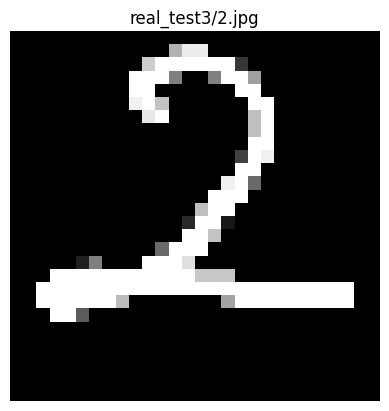

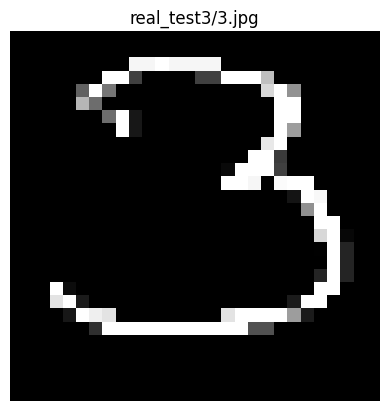

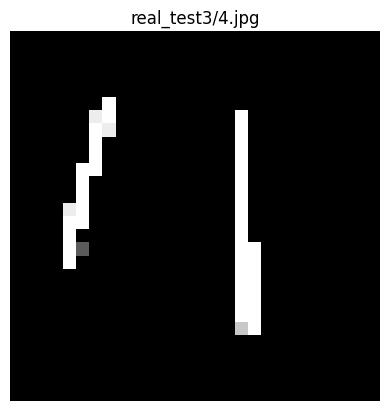

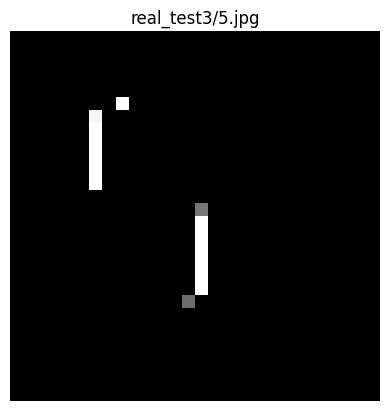

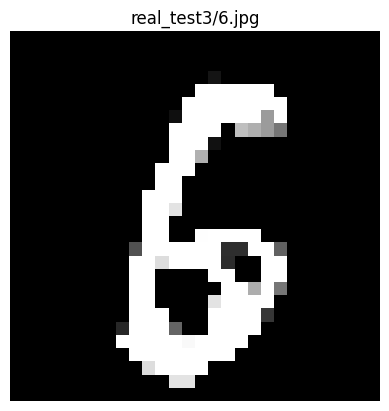

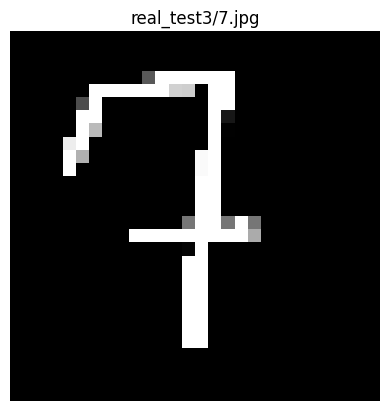

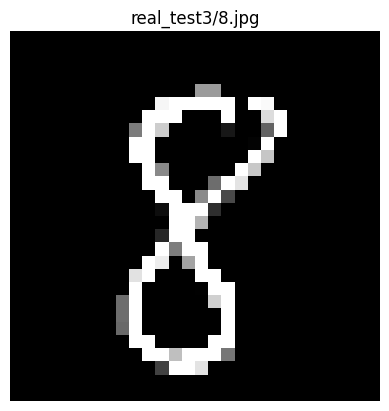

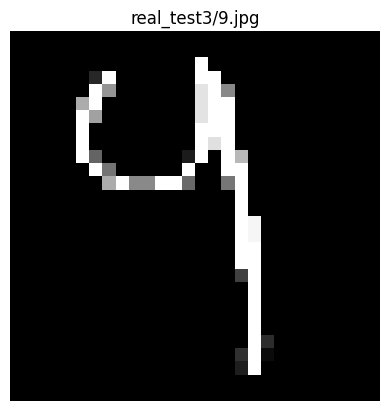

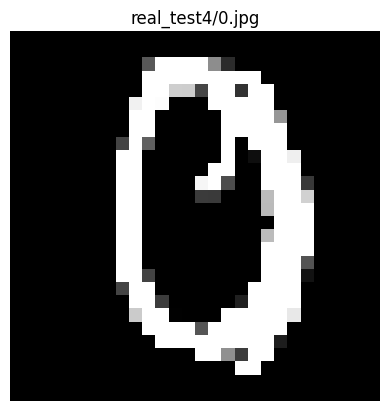

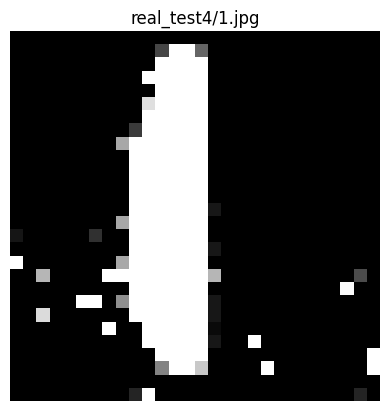

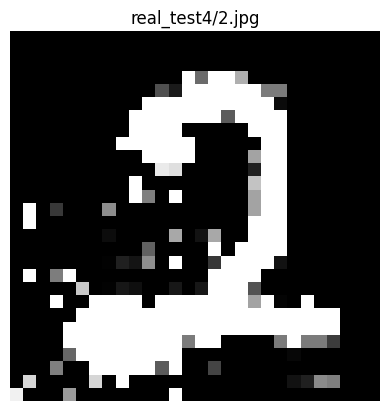

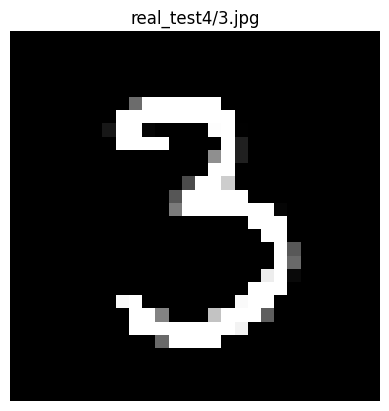

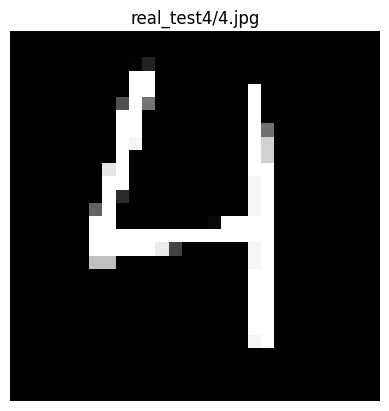

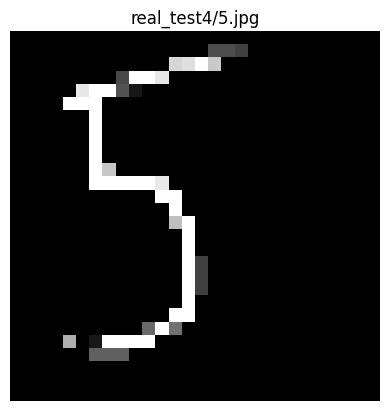

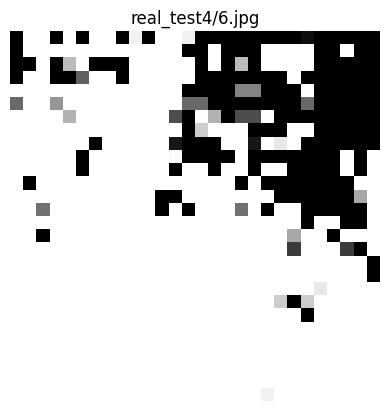

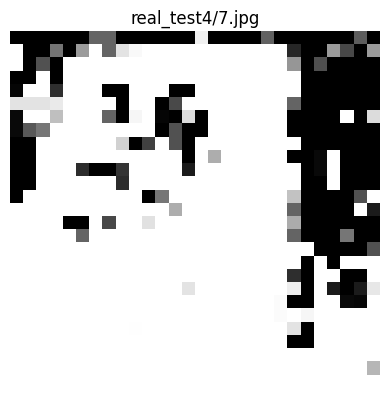

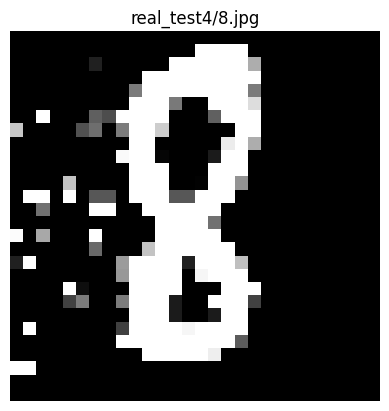

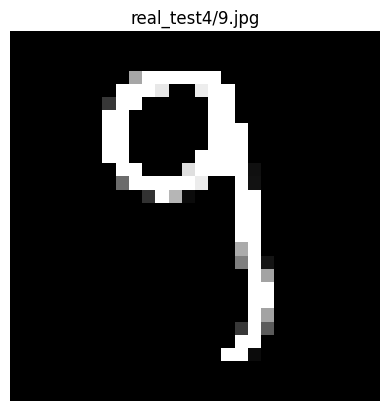

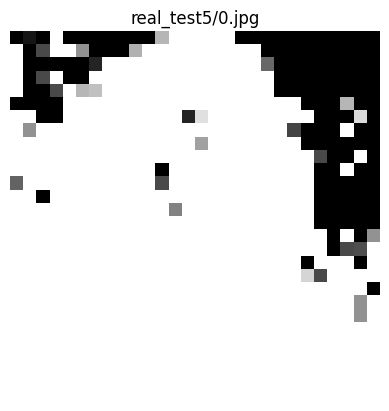

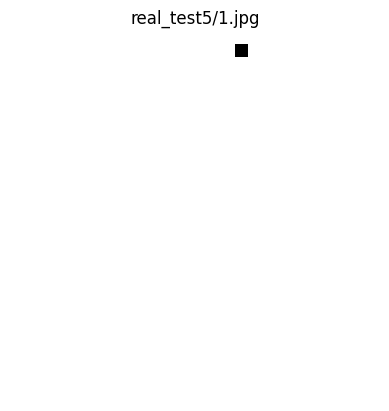

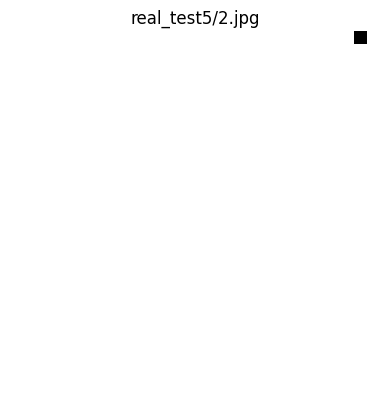

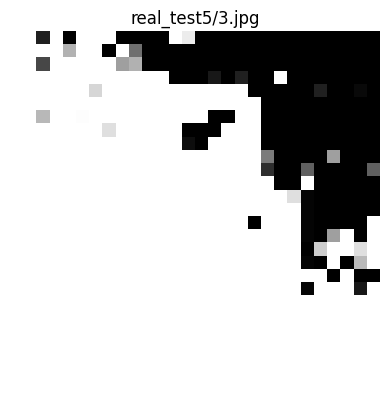

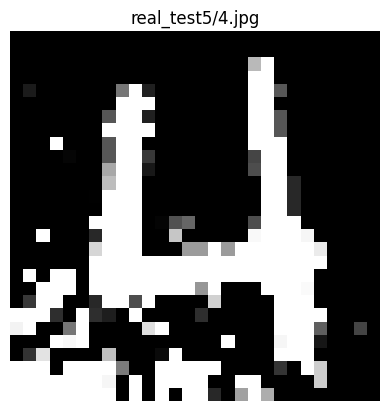

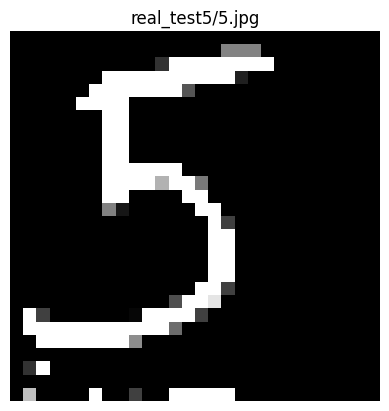

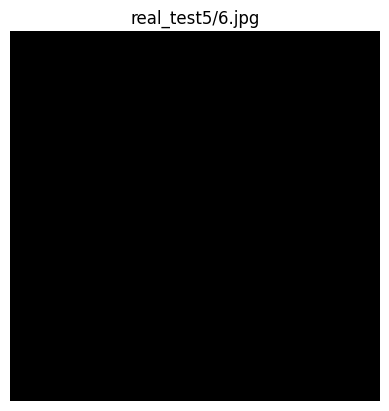

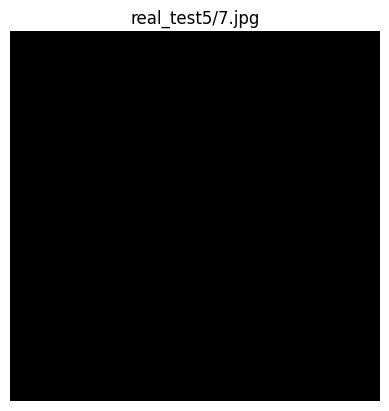

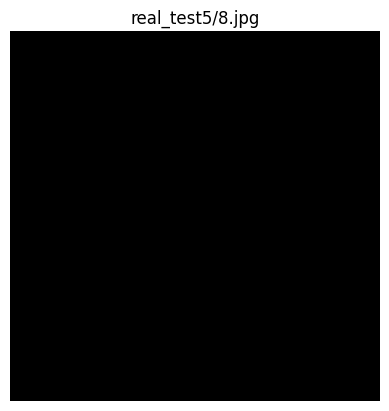

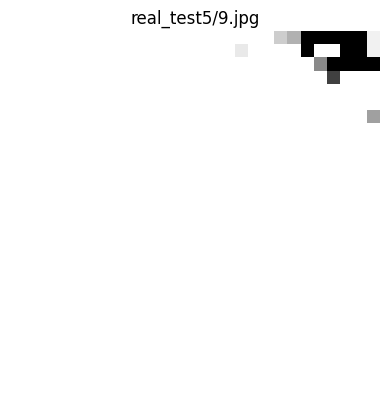

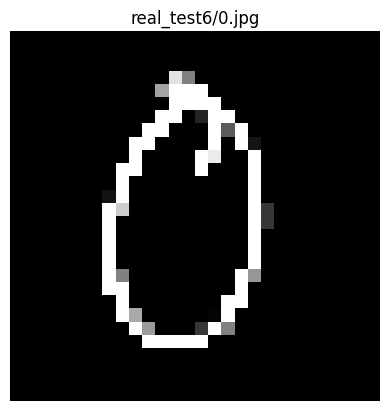

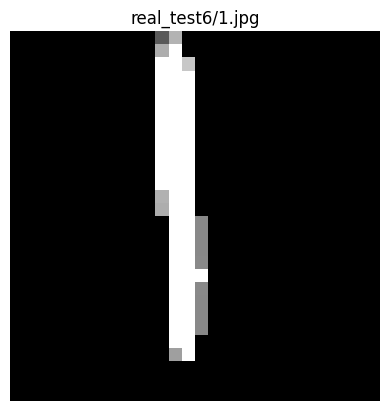

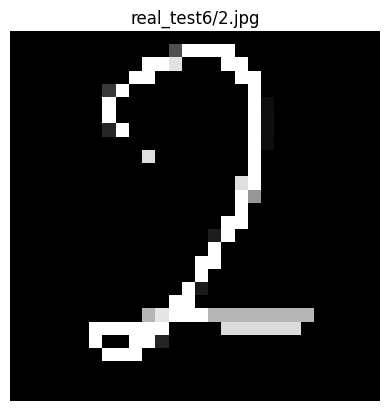

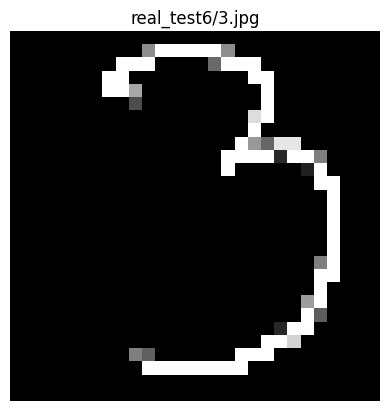

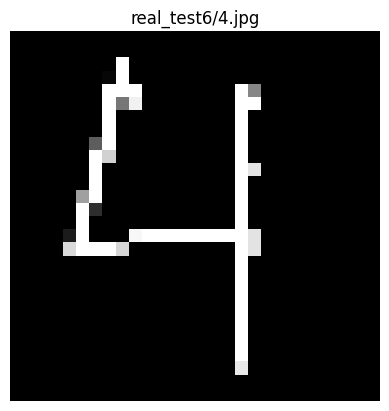

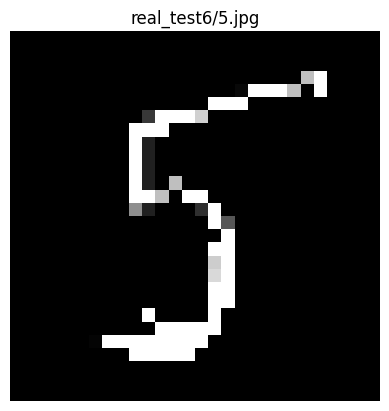

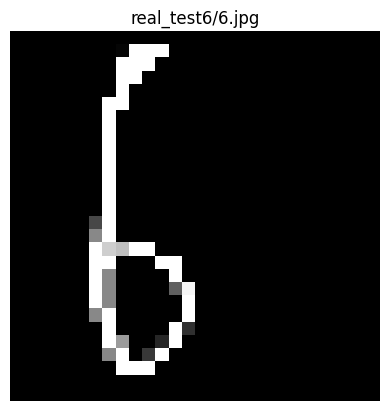

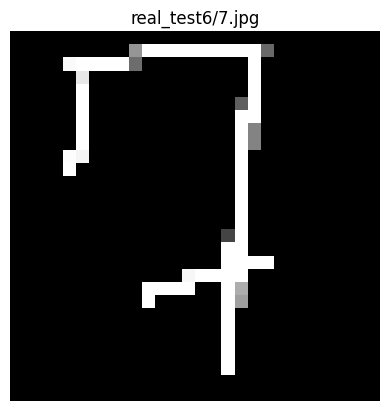

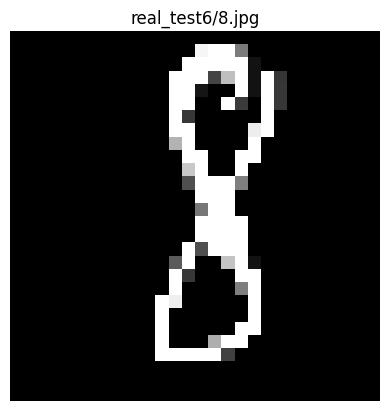

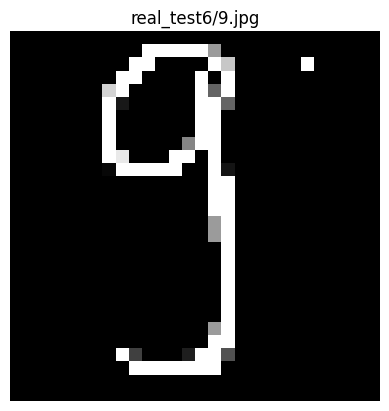

In [157]:
import cv2
import numpy as np

def load_image(filename, alpha=0.85, beta=2, threshold=130, dilation_kernel_size=3):
    # Load the image
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Apply thresholding to convert to black and white
    _, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

    # Invert the pixels
    img = cv2.bitwise_not(img)

    # Dilate the image to make area near white pixels also white
    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    # Resize the image to target size
    img = cv2.resize(img, (28, 28))

    # Reshape into a single sample with 1 channel
    img = img.reshape(-1, 28, 28, 1)

    # Prepare pixel data
    img = img.astype('float32')
    img = img / 255.0

    return img


for i in range(60):
  img = load_image(f"real_test{(i//10)+1}/{i%10}.jpg")

# Reshape the image to remove the batch dimension (if present)
  img = img.reshape(28, 28)

  # Display the image
  plt.imshow(img, cmap='gray')  # Display in grayscale
  plt.title(f"real_test{(i//10)+1}/{i%10}.jpg")
  plt.axis('off')  # Turn off axis
  plt.show()

1/1 [==============================] - 0s 108ms/step
The model predicts the digit as: 0
Confidence: 0.8253058


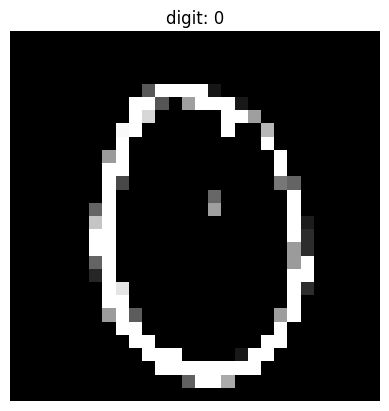

1/1 [==============================] - 0s 121ms/step
The model predicts the digit as: 1
Confidence: 0.9852938


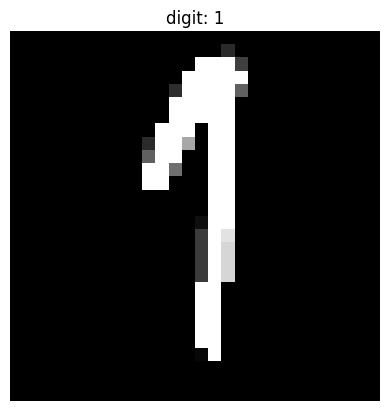

1/1 [==============================] - 0s 78ms/step
The model predicts the digit as: 3
Confidence: 0.8518275


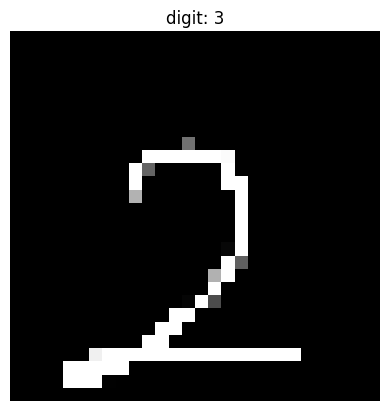

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 3
Confidence: 1.0


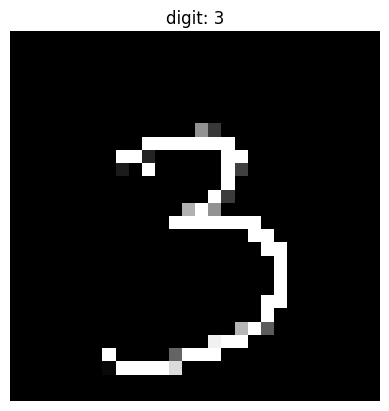

1/1 [==============================] - 0s 71ms/step
The model predicts the digit as: 4
Confidence: 0.99999154


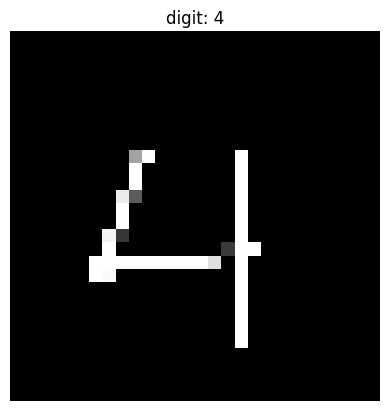

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 4
Confidence: 0.56277496


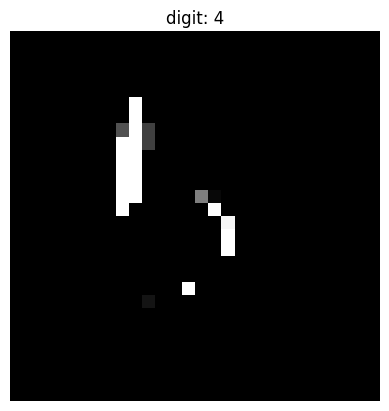

1/1 [==============================] - 0s 71ms/step
The model predicts the digit as: 6
Confidence: 0.94087994


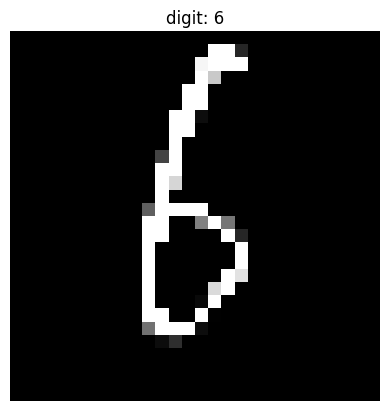

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 1
Confidence: 0.95676845


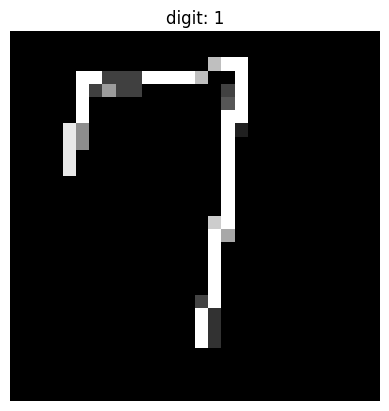

1/1 [==============================] - 0s 67ms/step
The model predicts the digit as: 8
Confidence: 0.99991107


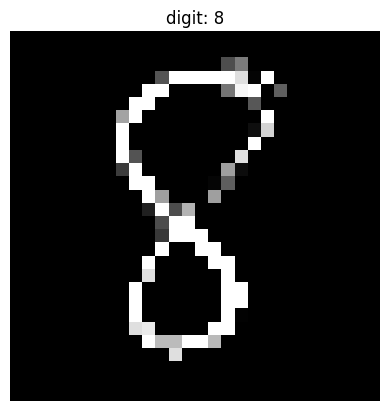

1/1 [==============================] - 0s 73ms/step
The model is not confident in its prediction.
Best fit: 4


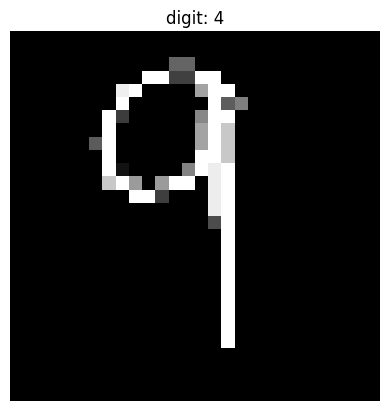

1/1 [==============================] - 0s 79ms/step
The model predicts the digit as: 0
Confidence: 0.99996185


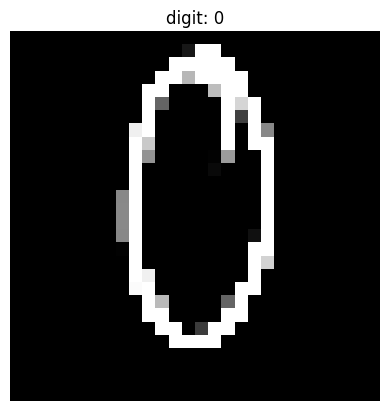

1/1 [==============================] - 0s 77ms/step
The model predicts the digit as: 1
Confidence: 0.9640621


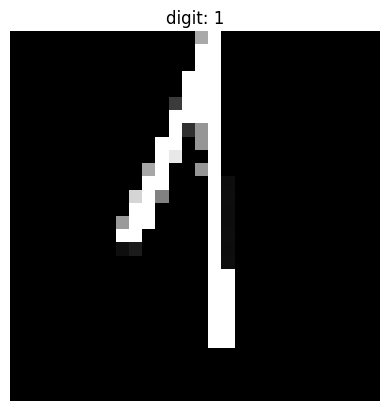

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 9
Confidence: 0.90586215


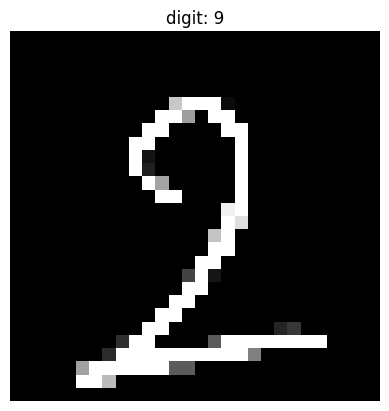

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 3
Confidence: 0.9999999


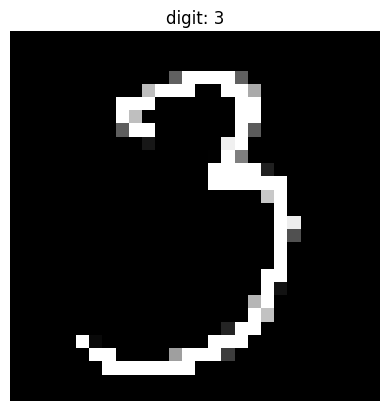

1/1 [==============================] - 0s 71ms/step
The model predicts the digit as: 4
Confidence: 0.9999988


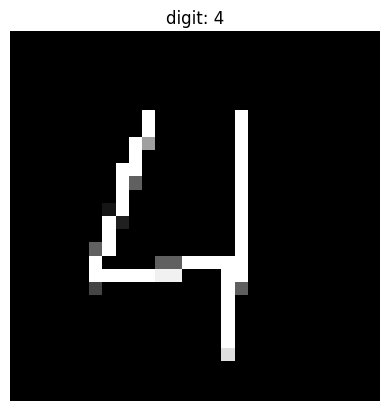

1/1 [==============================] - 0s 74ms/step
The model predicts the digit as: 5
Confidence: 0.9999982


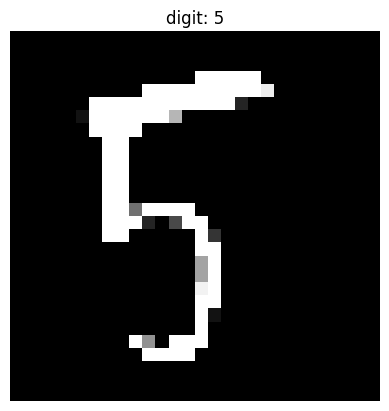

1/1 [==============================] - 0s 67ms/step
The model predicts the digit as: 5
Confidence: 0.94126284


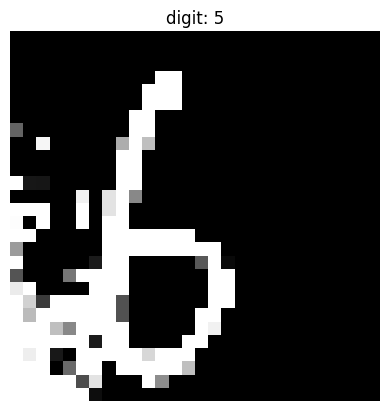

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 1
Confidence: 0.9991793


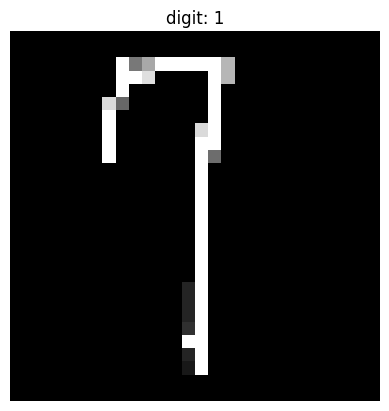

1/1 [==============================] - 0s 72ms/step
The model predicts the digit as: 8
Confidence: 0.9999881


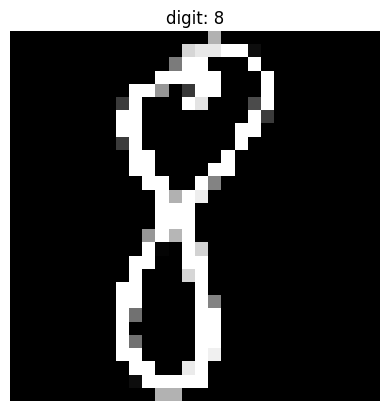

1/1 [==============================] - 0s 67ms/step
The model predicts the digit as: 7
Confidence: 0.71153736


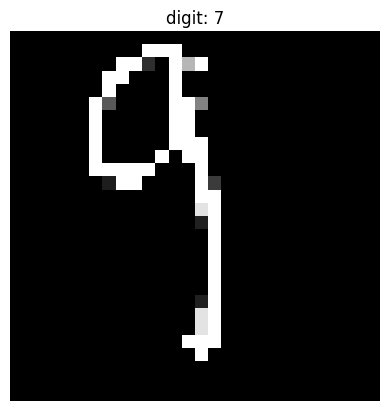

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 0
Confidence: 0.7551903


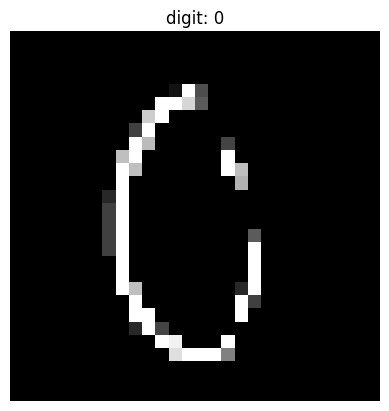

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 1
Confidence: 0.92652303


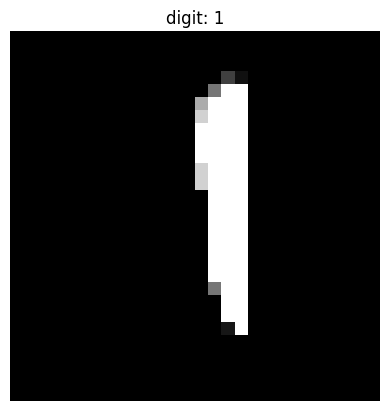

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 2
Confidence: 0.99999976


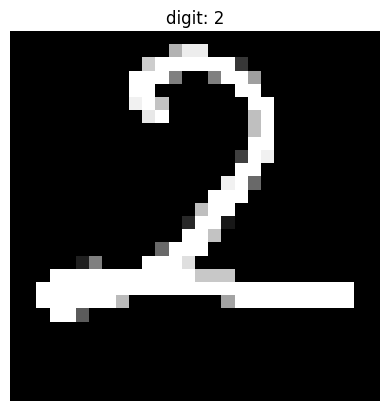

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 2
Confidence: 0.93864304


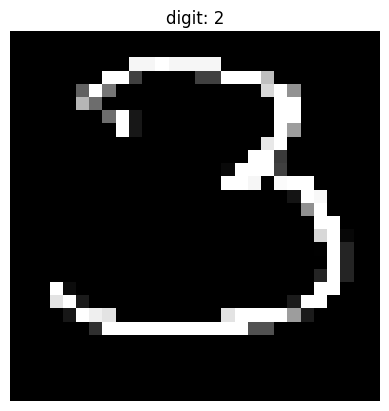

1/1 [==============================] - 0s 65ms/step
The model predicts the digit as: 4
Confidence: 0.95573854


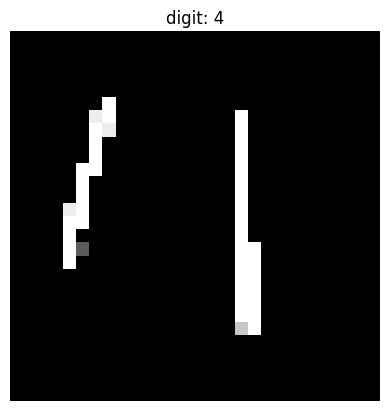

1/1 [==============================] - 0s 69ms/step
The model predicts the digit as: 1
Confidence: 0.50928134


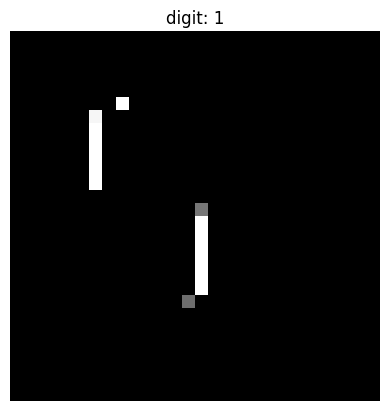

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 6
Confidence: 0.8810891


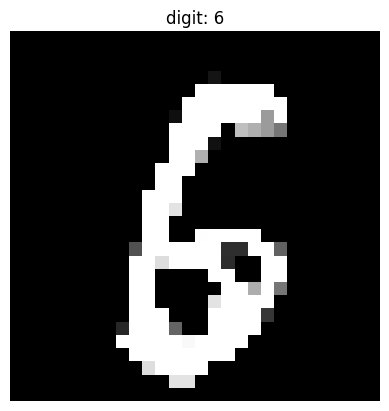

1/1 [==============================] - 0s 70ms/step
The model is not confident in its prediction.
Best fit: 3


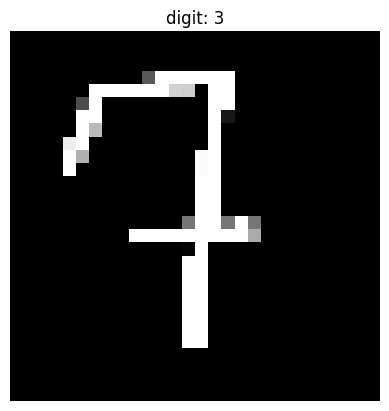

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 8
Confidence: 1.0


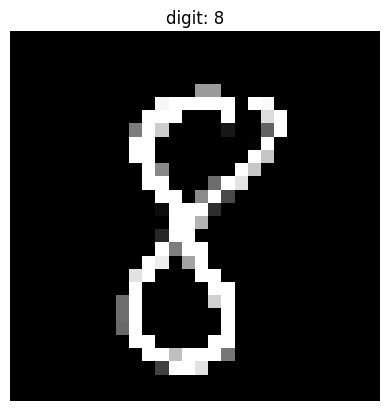

1/1 [==============================] - 0s 69ms/step
The model predicts the digit as: 7
Confidence: 0.609927


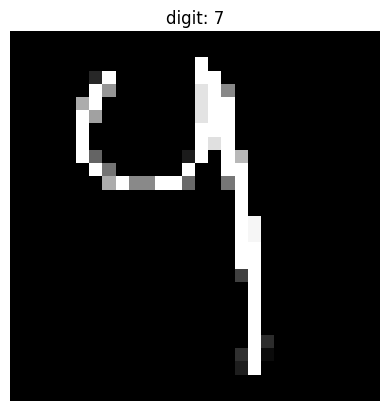

1/1 [==============================] - 0s 103ms/step
The model predicts the digit as: 0
Confidence: 0.9998311


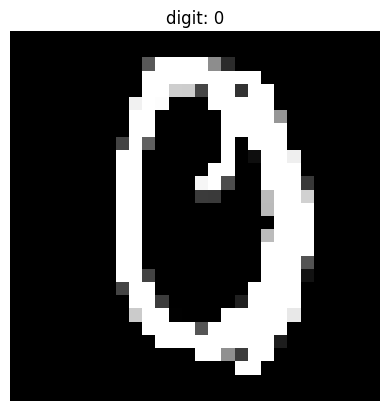

1/1 [==============================] - 0s 97ms/step
The model predicts the digit as: 1
Confidence: 0.7448321


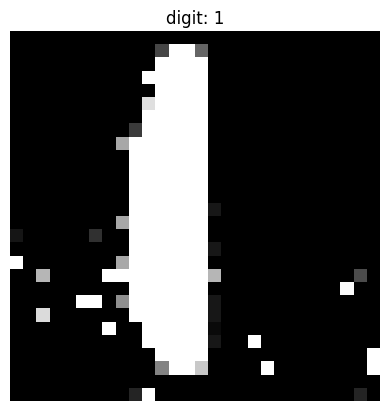

1/1 [==============================] - 0s 96ms/step
The model predicts the digit as: 2
Confidence: 0.99991226


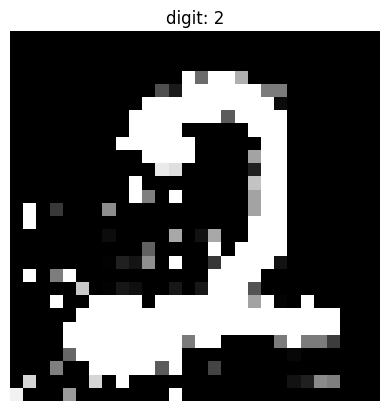

1/1 [==============================] - 0s 102ms/step
The model predicts the digit as: 3
Confidence: 1.0


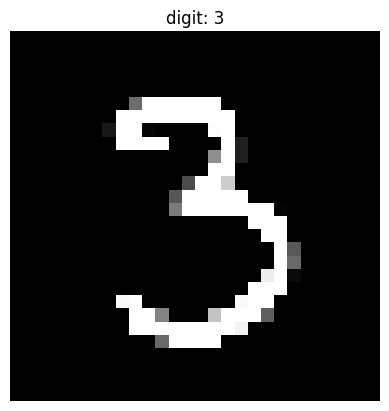

1/1 [==============================] - 0s 104ms/step
The model predicts the digit as: 4
Confidence: 0.9999993


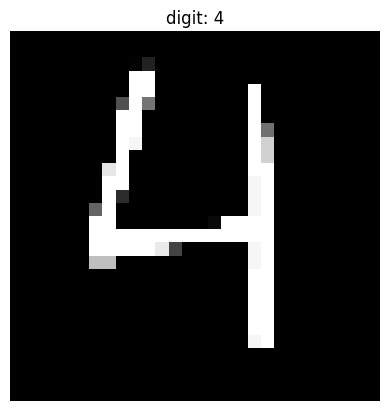

1/1 [==============================] - 0s 63ms/step
The model predicts the digit as: 5
Confidence: 0.6263713


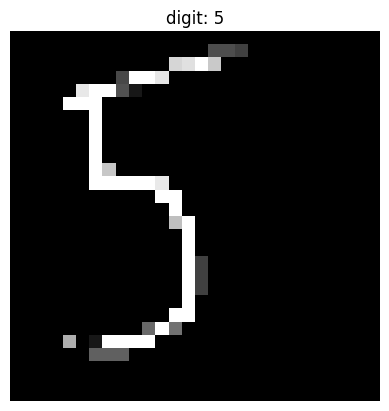

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 8
Confidence: 0.9999995


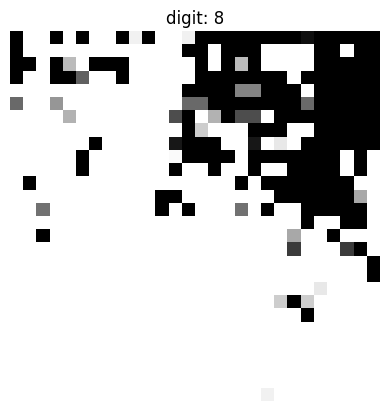

1/1 [==============================] - 0s 67ms/step
The model predicts the digit as: 8
Confidence: 0.9995394


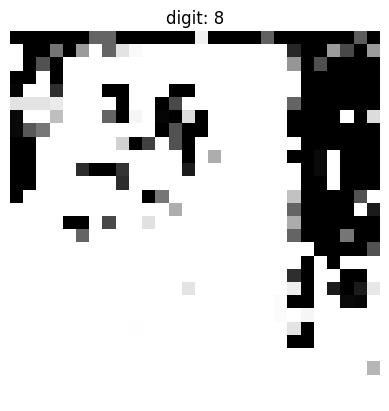

1/1 [==============================] - 0s 69ms/step
The model predicts the digit as: 8
Confidence: 1.0


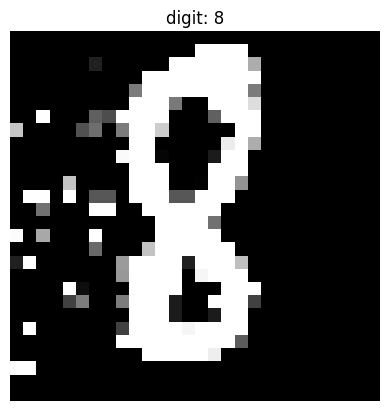

1/1 [==============================] - 0s 71ms/step
The model predicts the digit as: 3
Confidence: 0.8364469


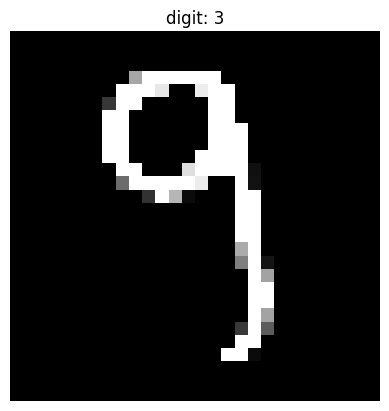

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 8
Confidence: 0.87004584


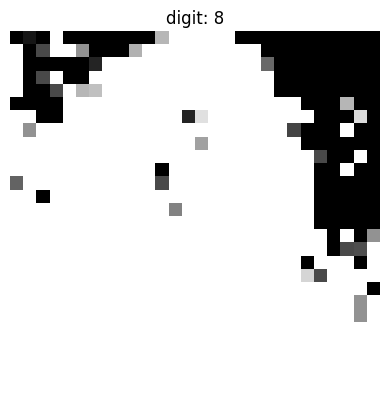

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 8
Confidence: 0.70700604


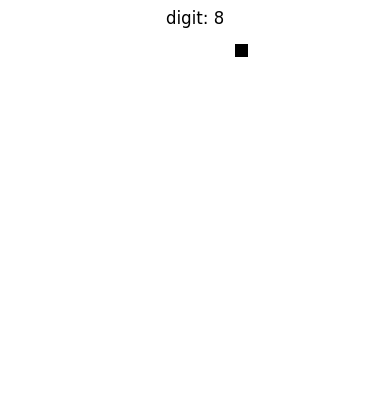

1/1 [==============================] - 0s 61ms/step
The model predicts the digit as: 8
Confidence: 0.74792355


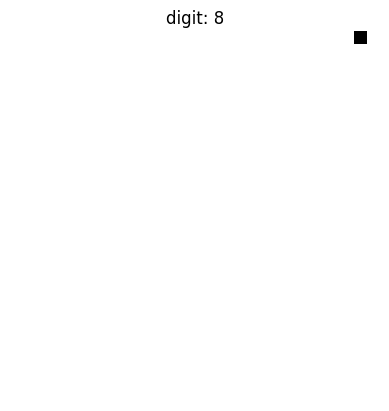

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 8
Confidence: 0.7125288


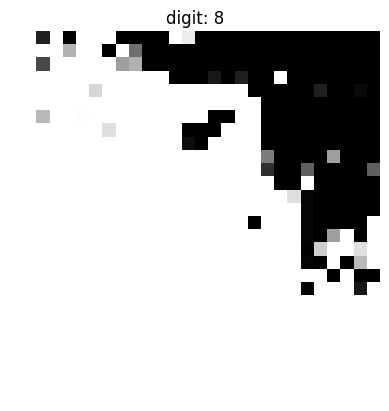

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 4
Confidence: 0.99966455


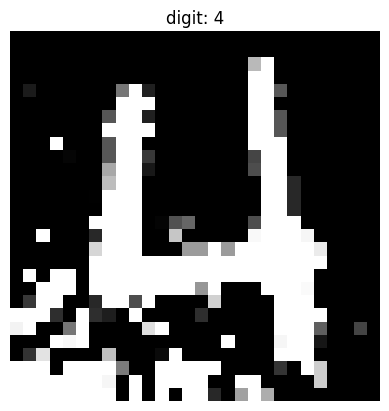

1/1 [==============================] - 0s 76ms/step
The model predicts the digit as: 5
Confidence: 0.9178803


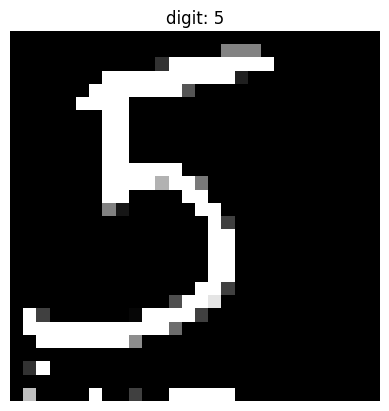

1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 8
Confidence: 0.7642823


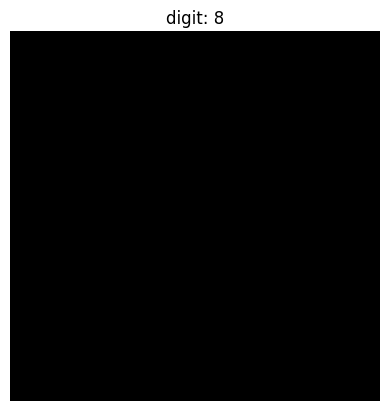

1/1 [==============================] - 0s 65ms/step
The model predicts the digit as: 8
Confidence: 0.7642823


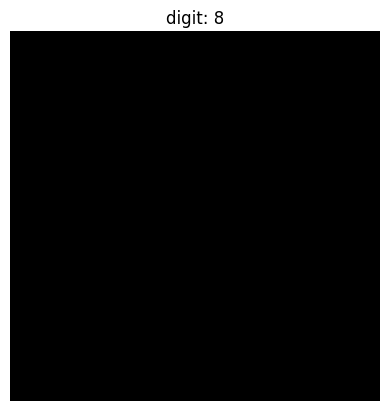

1/1 [==============================] - 0s 69ms/step
The model predicts the digit as: 8
Confidence: 0.7642823


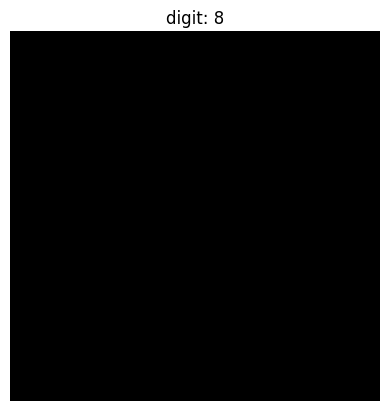

1/1 [==============================] - 0s 65ms/step
The model predicts the digit as: 8
Confidence: 0.6139025


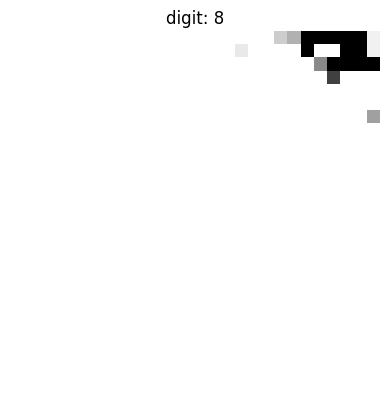

1/1 [==============================] - 0s 67ms/step
The model predicts the digit as: 0
Confidence: 0.99668306


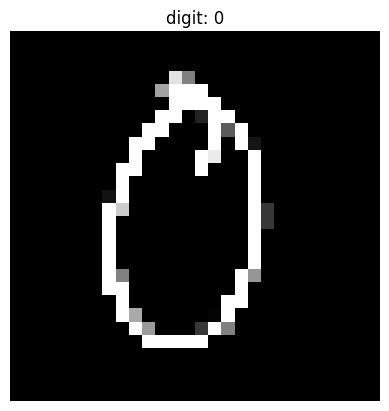

1/1 [==============================] - 0s 64ms/step
The model predicts the digit as: 1
Confidence: 0.9939295


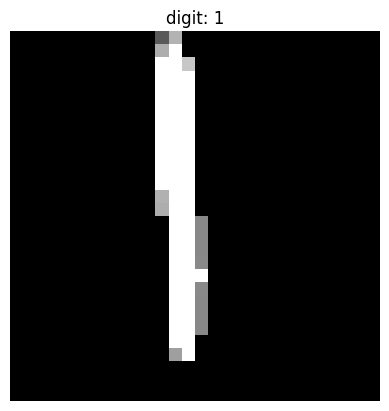

1/1 [==============================] - 0s 77ms/step
The model predicts the digit as: 2
Confidence: 0.78032255


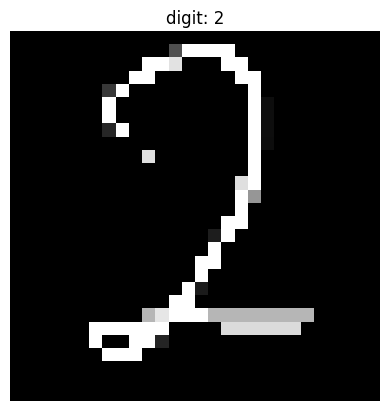

1/1 [==============================] - 0s 68ms/step
The model predicts the digit as: 3
Confidence: 0.5955666


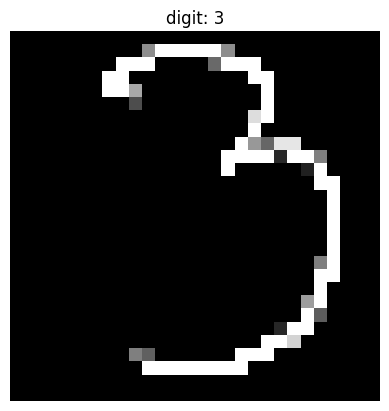

1/1 [==============================] - 0s 75ms/step
The model predicts the digit as: 4
Confidence: 0.9999995


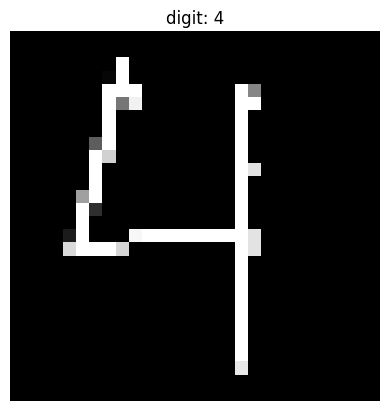

1/1 [==============================] - 0s 71ms/step
The model predicts the digit as: 5
Confidence: 0.99999976


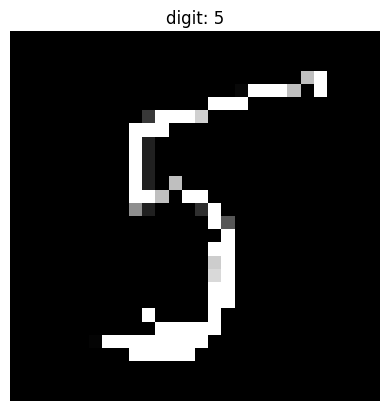

1/1 [==============================] - 0s 74ms/step
The model predicts the digit as: 6
Confidence: 0.7901885


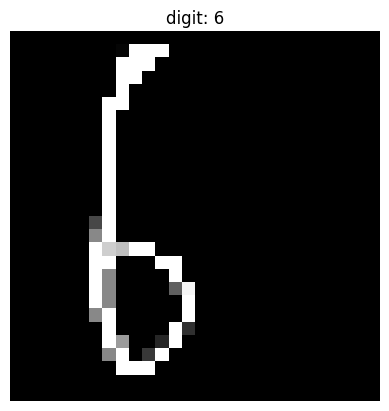

1/1 [==============================] - 0s 71ms/step
The model is not confident in its prediction.
Best fit: 1


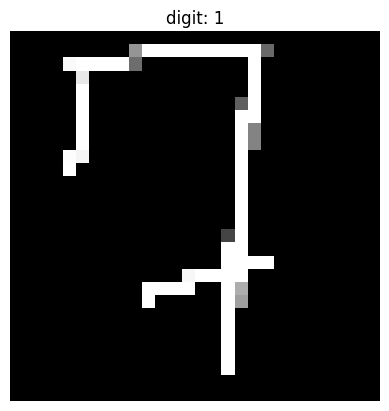

1/1 [==============================] - 0s 76ms/step
The model predicts the digit as: 8
Confidence: 0.99999976


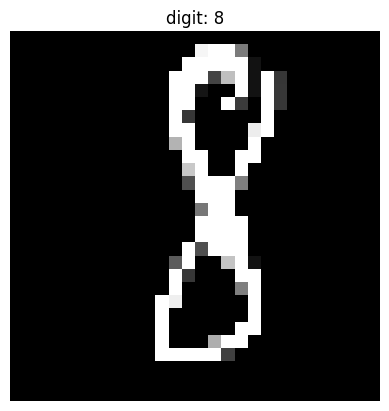

1/1 [==============================] - 0s 69ms/step
The model predicts the digit as: 3
Confidence: 0.98317564


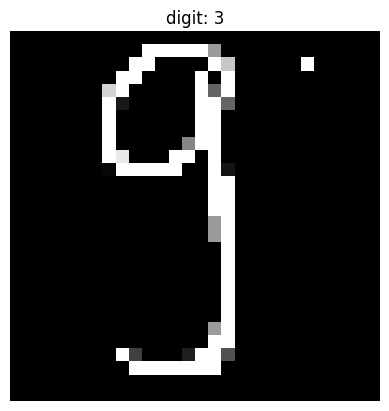

accuracy is:$60.0% 


In [158]:
# load an image and predict the class
def run_example():
  # load the image
  prev_path = "real_test"
  correct_predictions = 0
  total_images = 60
  for i in range(60):
    img = load_image(f"{prev_path}{(i//10)+1}/{i%10}.jpg")
    # load model
    model = load_model('final_model.h5')

    # predict the class
    predict_value = model.predict(img)

    digit = argmax(predict_value)
    confidence= predict_value[0][digit]
    if str(digit) == str(i%10):
      correct_predictions += 1
    if confidence >= 0.5:
      print("The model predicts the digit as:", digit)
      print("Confidence:", confidence)
    else:
      print("The model is not confident in its prediction.")
      print("Best fit:", digit)

    #reshape image to 28 - 28 to display
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title(f'digit: {digit}')
    plt.show()

  print(f"accuracy is:${correct_predictions*100/total_images}% ")
    # print(digit)

run_example()



In [ ]:
# entry point, run the example


# Reshape the image to remove the batch dimension (if present)


# Display the image


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


OSError: No file or directory found at final_model.h5

In [120]:
import os

# Iterate over file names from 0.png to 9.png
prev_path = "real_test4/"
for i in range(10):
    filename = prev_path + str(i) + ".jpg"
    # Remove the file forcefully using Bash command
    os.system(f'rm -f {filename}')